In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.compose import ColumnTransformer
seed = 42

In [2]:
df = pd.read_csv('data.csv')

In [3]:
X, y = df.iloc[:,1:-1], df.iloc[:,-1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [5]:
y_train=np.log(y_train)
y_test=np.log(y_test)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 1023 to 1126
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1095 non-null   int64  
 1   MSZoning       1095 non-null   object 
 2   LotFrontage    895 non-null    float64
 3   LotArea        1095 non-null   int64  
 4   Street         1095 non-null   object 
 5   Alley          70 non-null     object 
 6   LotShape       1095 non-null   object 
 7   LandContour    1095 non-null   object 
 8   Utilities      1095 non-null   object 
 9   LotConfig      1095 non-null   object 
 10  LandSlope      1095 non-null   object 
 11  Neighborhood   1095 non-null   object 
 12  Condition1     1095 non-null   object 
 13  Condition2     1095 non-null   object 
 14  BldgType       1095 non-null   object 
 15  HouseStyle     1095 non-null   object 
 16  OverallQual    1095 non-null   int64  
 17  OverallCond    1095 non-null   int64  
 18  YearBuilt 

## Feature Engineering

#### Discard The Fatures that has more than 80% missing value

In [9]:
unimp = X_train.columns[(X_train.isnull().sum()/X_train.shape[0]) > 0.8]
X_train.drop(columns=unimp,inplace=True)

#### Median and Mode Imputation for Numerical and Categorical Variables

In [11]:
num_feat = X_train.select_dtypes('number').columns
cat_feat = X_train.select_dtypes('object').columns

In [12]:
si_med = SimpleImputer(strategy='median').set_output(transform='pandas')
si_mode = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
num_imp = si_med.fit_transform(X_train[num_feat])
cat_imp = si_mode.fit_transform(X_train[cat_feat])
X_train_imp = pd.concat([num_imp,cat_imp],axis=1)

In [13]:
X_test_num_imp = si_med.transform(X_test[num_feat])
X_test_cat_imp = si_mode.transform(X_test[cat_feat])
X_test_imp = pd.concat([X_test_num_imp,X_test_cat_imp],axis=1)

#### Target Encoding of Categorical Values With Median 

In [15]:
cat_feat = X_train_imp.select_dtypes('object').columns
train = pd.concat([X_train,y_train],axis=1)
for i in cat_feat:
    median_encoding = train.groupby(i)['SalePrice'].median().to_dict()
    X_train_imp[i] = X_train_imp[i].map(median_encoding)
    X_test_imp[i] = X_test_imp[i].map(median_encoding)

#### Univariate Feature Selection

In [17]:
mir = mutual_info_regression(X_train_imp,y_train,random_state=seed)

In [18]:
uni_feat_imp=pd.DataFrame(dict(Features=X_train_imp.columns, mir = mir)).sort_values(by='mir',ascending=False)

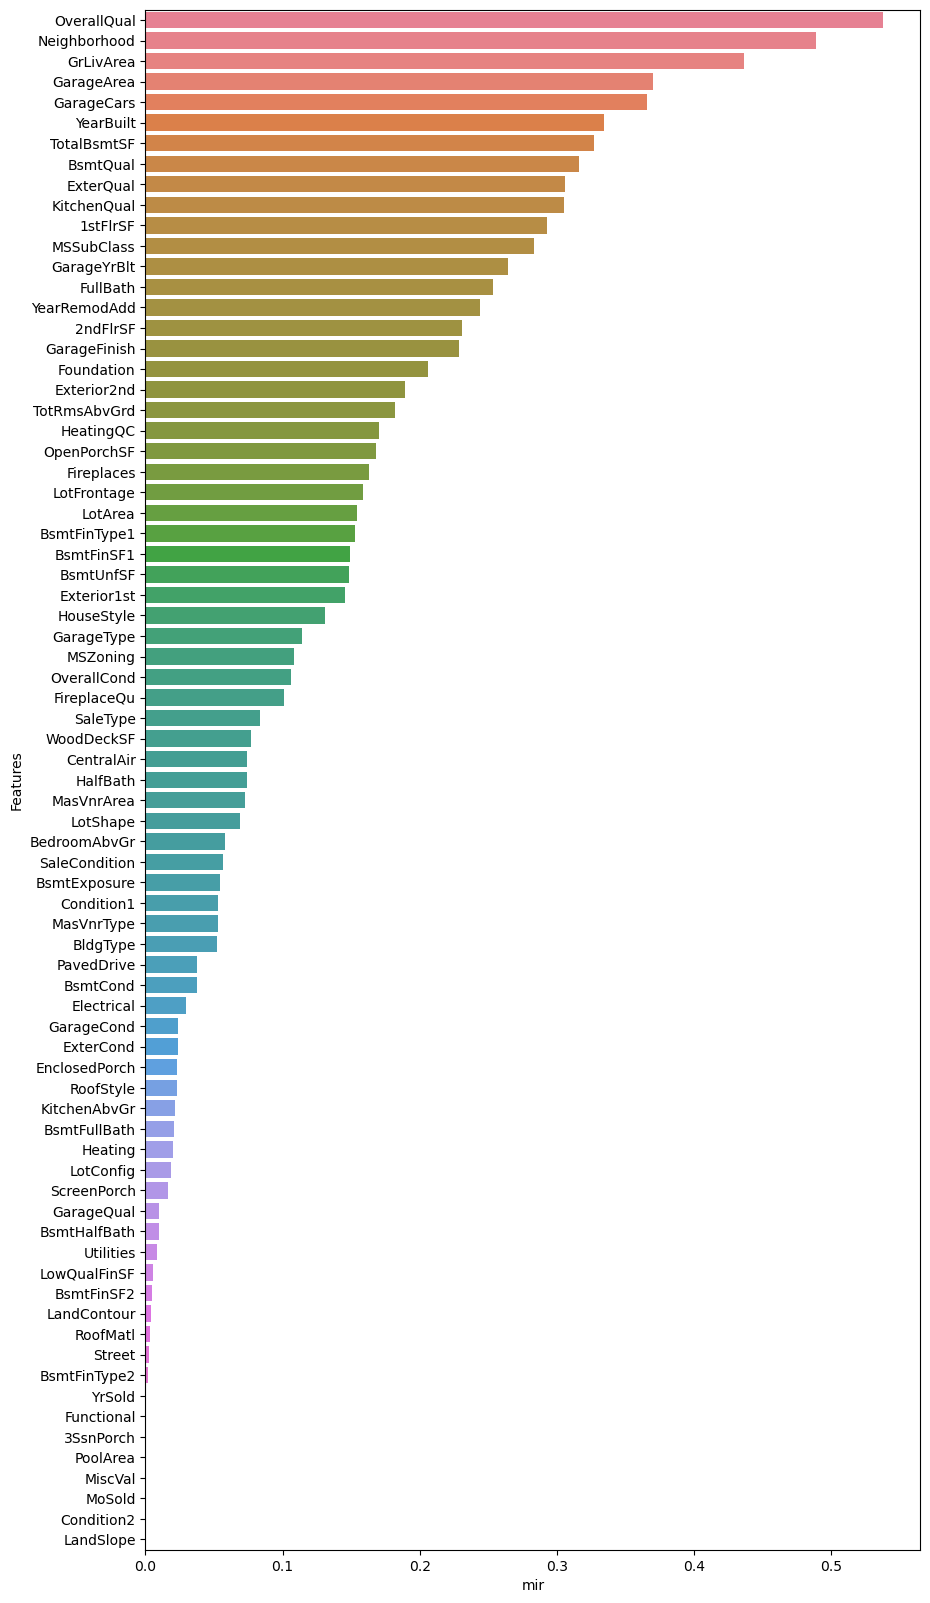

In [19]:
plt.figure(figsize=(10,20))
bar = sns.barplot(uni_feat_imp,y='Features',x='mir',hue='Features')
plt.show()

#### Multivariate Feature Selection ( Random Forest as base estimator)

In [21]:
col_imp_dic = {col:[] for col,key in zip(uni_feat_imp.Features,[[]]*uni_feat_imp.Features.shape[0])}
mse_scores = []
n_feats = []
feat_per_iter = 5
for i in range(1,int(X_train_imp.shape[1]/feat_per_iter)+2):
    predictors = uni_feat_imp.Features[:i*feat_per_iter]
    sub_X = X_train_imp[predictors]
    sub_X_train,sub_X_test,sub_y_train,sub_y_test = train_test_split(sub_X,y_train,test_size=0.3,random_state=seed)
    rf = RandomForestRegressor(random_state=seed)
    rf.fit(sub_X_train,sub_y_train)
    score = mse(sub_y_test,rf.predict(sub_X_test))
    n_feats.append(len(predictors))
    mse_scores.append(score)
    feat_imp = {key:val for key,val in zip(predictors, rf.feature_importances_)}
    for col in predictors:
        col_imp_dic[col].append(feat_imp[col])



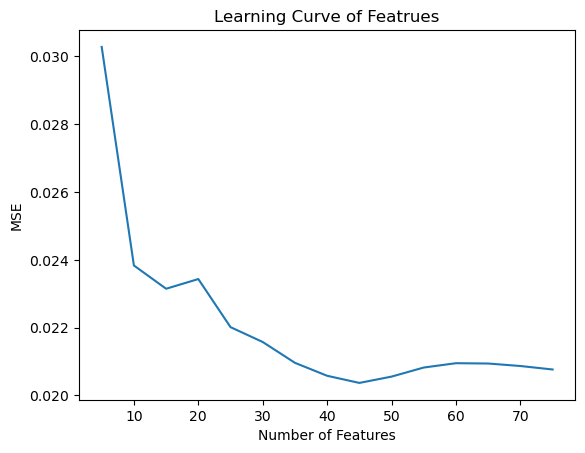

In [22]:
line = sns.lineplot(x=n_feats,y=mse_scores)
line.set_title('Learning Curve of Featrues')
line.set_ylabel('MSE')
line.set_xlabel('Number of Features')
plt.show()

In [23]:
feat_tile = []
imps = []
for key in uni_feat_imp.Features:
    
    feat_tile.extend([key]*len(col_imp_dic[key]))
    imps.extend(col_imp_dic[key])
imp_df = pd.DataFrame(dict(Feature=feat_tile,importance=imps))

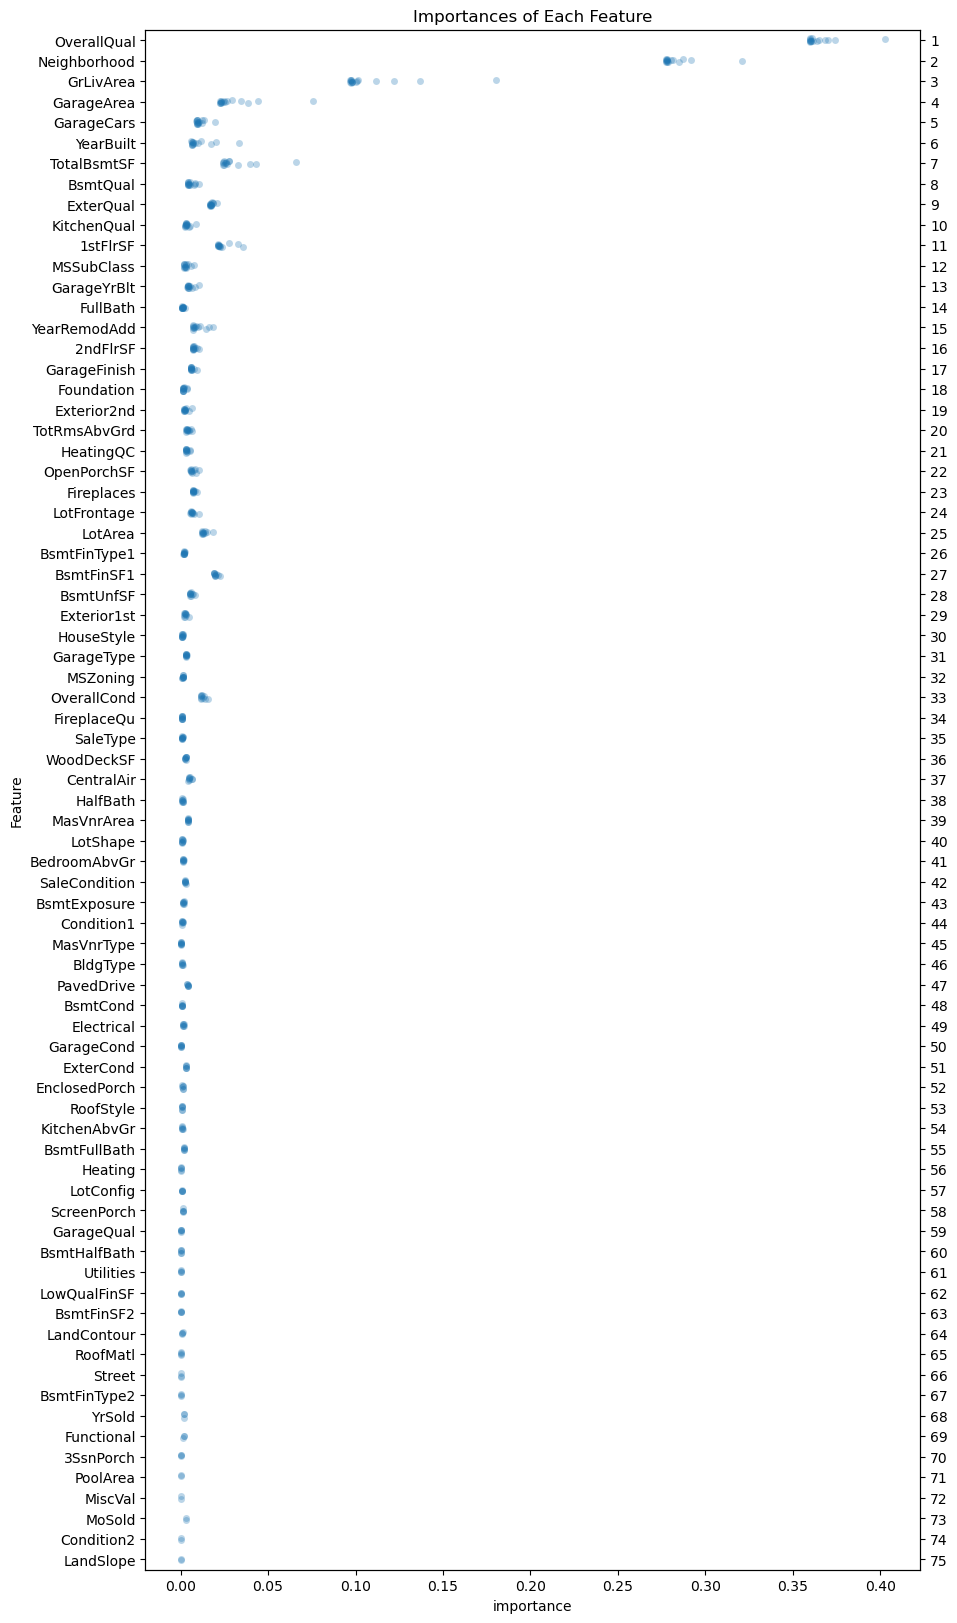

In [24]:
plt.figure(figsize=(10,20))
strip = sns.stripplot(imp_df,x='importance',y='Feature',alpha=0.3)
strip.set_title('Importances of Each Feature')
left_ax = strip.twinx()
left_ax.set_yticks(np.array(strip.get_yticks())+0.5,np.arange(imp_df.Feature.nunique(),0,-1))
left_ax.set_ylim(0,imp_df.Feature.nunique())
plt.show()

In [25]:
important_features = uni_feat_imp.Features[:45].values
important_features

array(['OverallQual', 'Neighborhood', 'GrLivArea', 'GarageArea',
       'GarageCars', 'YearBuilt', 'TotalBsmtSF', 'BsmtQual', 'ExterQual',
       'KitchenQual', '1stFlrSF', 'MSSubClass', 'GarageYrBlt', 'FullBath',
       'YearRemodAdd', '2ndFlrSF', 'GarageFinish', 'Foundation',
       'Exterior2nd', 'TotRmsAbvGrd', 'HeatingQC', 'OpenPorchSF',
       'Fireplaces', 'LotFrontage', 'LotArea', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtUnfSF', 'Exterior1st', 'HouseStyle',
       'GarageType', 'MSZoning', 'OverallCond', 'FireplaceQu', 'SaleType',
       'WoodDeckSF', 'CentralAir', 'HalfBath', 'MasVnrArea', 'LotShape',
       'BedroomAbvGr', 'SaleCondition', 'BsmtExposure', 'Condition1',
       'MasVnrType'], dtype=object)

We are using these 30 Feature for our modelling

In [27]:
pd.concat([X_train_imp[important_features],y_train],axis=1).to_csv('train.csv',index=False)
pd.concat([X_test_imp[important_features],y_test],axis=1).to_csv('test.csv',index=False)